## Dependencies

In [2]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model, Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard

width = 320
height = 240
name_model = "unet_small"
tb = TensorBoard('logs/{}'.format(model_name))
cp = ModelCheckpoint('{}.h5'.format(model_name))

## Data importation
Let's load our sample

In [9]:
X = np.load('X.npy')
y = np.load('y.npy')[:,:,:,0:1] #trying to predict only the mask 0 (the one corresponding to the board)
print(X.shape, '\n', y.shape)

(99, 240, 320, 3) 
 (99, 240, 320, 1)


## Vizualize 1 sample

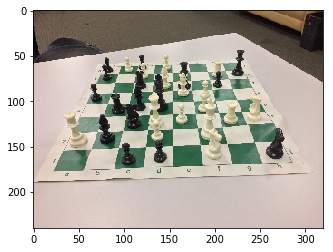

<function matplotlib.pyplot.show(*args, **kw)>

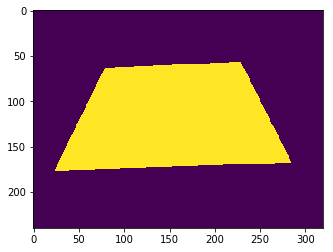

In [6]:
plt.imshow(X[0])
plt.show()
plt.imshow(y[0,:,:,0])
plt.show

## Training set and testing set creation

In [4]:
np.random.seed(666)
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
treshold = np.int(idx.shape[0]*0.8)
X_train = X[:treshold]
X_valid = X[treshold:]
y_train = y[:treshold]
y_valid = y[treshold:]

# for future testing, using model_testing.ipynb notebook.
np.save('X_valid.npy', X_valid)
np.save('y_valid.npy', y_valid)

## Model creation : small unet
We decrease drastically the usual number of filters on the Unet since we want :

1. Fast training for fast experimentation
2. Avoid overfitting
3. Save electricity bill :)


In [6]:
def get_unet():

    inputs = Input((height, width, 3))
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model
try:
    model = load_model('{}.h5'.format(model_name))
except:
    print("Not pre-existing model, creating a new one...")
    model = get_unet()

## Model training

In [ ]:
model.fit(X_train, y_train, validation_data=[X_valid, y_valid], batch_size = 1, epochs = 3000, callbacks = [tb,cp], verbose = 0)